<a href="https://www.kaggle.com/code/joshuaokolo/simple-logistic-regression-with-pytorch?scriptVersionId=103948024" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import Required Libraries

In [1]:

## Import the usual libraries
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## print out the pytorch version used (1.31 at the time of this tutorial)
print(torch.__version__)

1.11.0


## Check GPU Availability

In [2]:
## configuration to detect cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


## For those running in colab, to import files

In [3]:
"""
## importing dataset
from google.colab import drive
drive.mount('gdrive', force_remount=True)
"""

"\n## importing dataset\nfrom google.colab import drive\ndrive.mount('gdrive', force_remount=True)\n"

## Import Dataset and Data Transformation

In [4]:
## configure root folder on your gdrive
data_dir = '../input/hymenoptera-data/hymenoptera_data/'

## custom transformer to flatten the image tensors
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        result = torch.reshape(img, self.new_size)
        return result

## transformations used to standardize and normalize the datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,)) # flattens the data
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ReshapeTransform((-1,)) # flattens the data
    ]),
}

## load the correspoding folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

## load the entire dataset; we are not using minibatches here
train_dataset = torch.utils.data.DataLoader(image_datasets['train'],
                                            batch_size=len(image_datasets['train']),
                                            shuffle=True)
test_dataset = torch.utils.data.DataLoader(image_datasets['val'],
                                           batch_size=len(image_datasets['val']),
                                           shuffle=True)

## Print a Sample

Dimension of image: torch.Size([244, 150528]) 
 Dimension of labels torch.Size([244])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2314.)
  if __name__ == "__main__":


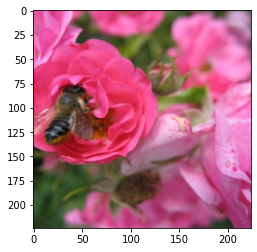

In [5]:
## load the entire dataset
x, y = next(iter(train_dataset))

## print one example
dim = x.shape[1]
print("Dimension of image:", x.shape, "\n", 
      "Dimension of labels", y.shape)

plt.imshow(x[160].reshape(1, 3, 224, 224).squeeze().T.numpy())

## Build Model

In [6]:
class LR(nn.Module):
    def __init__(self, dim, lr=torch.scalar_tensor(0.01)):
        super(LR, self).__init__()
        # intialize parameters
        self.w = torch.zeros(dim, 1, dtype=torch.float).to(device)
        self.b = torch.scalar_tensor(0).to(device)
        self.grads = {"dw": torch.zeros(dim, 1, dtype=torch.float).to(device),
                      "db": torch.scalar_tensor(0).to(device)}
        self.lr = lr.to(device)

    def forward(self, x):
        ## compute forward
        z = torch.mm(self.w.T, x)
        a = self.sigmoid(z)
        return a

    def sigmoid(self, z):
        return 1/(1 + torch.exp(-z))

    def backward(self, x, yhat, y):
        ## compute backward
        self.grads["dw"] = (1/x.shape[1]) * torch.mm(x, (yhat - y).T)
        self.grads["db"] = (1/x.shape[1]) * torch.sum(yhat - y)
    
    def optimize(self):
        ## optimization step
        self.w = self.w - self.lr * self.grads["dw"]
        self.b = self.b - self.lr * self.grads["db"]
## utility functions
def loss(yhat, y):
    m = y.size()[1]
    return -(1/m)* torch.sum(y*torch.log(yhat) + (1 - y)* torch.log(1-yhat))

def predict(yhat, y):
    y_prediction = torch.zeros(1, y.size()[1])
    for i in range(yhat.size()[1]):
        if yhat[0, i] <= 0.5:
            y_prediction[0, i] = 0
        else:
            y_prediction[0, i] = 1
    return 100 - torch.mean(torch.abs(y_prediction - y)) * 100

## Pretest Model

In [7]:
## model pretesting
x, y = next(iter(train_dataset))

## flatten/transform the data
x_flatten = x.T
y = y.unsqueeze(0) 

## num_px is the dimension of the images
dim = x_flatten.shape[0]

## model instance
model = LR(dim)
model.to(device)
yhat = model.forward(x_flatten.to(device))
yhat = yhat.data.cpu()

## calculate loss
cost = loss(yhat, y)
prediction = predict(yhat, y)
print("Cost: ", cost)
print("Accuracy: ", prediction)

## backpropagate
model.backward(x_flatten.to(device), yhat.to(device), y.to(device))
model.optimize()

Cost:  tensor(0.6931)
Accuracy:  tensor(50.4098)


## Train Model

In [8]:
## hyperparams
costs = []
dim = x_flatten.shape[0]
learning_rate = torch.scalar_tensor(0.0001).to(device)
num_iterations = 100
lrmodel = LR(dim, learning_rate)
lrmodel.to(device)

## transform the data
def transform_data(x, y):
    x_flatten = x.T
    y = y.unsqueeze(0) 
    return x_flatten, y 

## training the model
for i in range(num_iterations):
    x, y = next(iter(train_dataset))
    test_x, test_y = next(iter(test_dataset))
    x, y = transform_data(x, y)
    test_x, test_y = transform_data(test_x, test_y)

    # forward
    yhat = lrmodel.forward(x.to(device))
    cost = loss(yhat.data.cpu(), y)
    train_pred = predict(yhat, y)
        
    # backward
    lrmodel.backward(x.to(device), 
                    yhat.to(device), 
                    y.to(device))
    lrmodel.optimize()
    ## test
    yhat_test = lrmodel.forward(test_x.to(device))
    test_pred = predict(yhat_test, test_y)

    if i % 10 == 0:
        costs.append(cost)

    if i % 10 == 0:
        print("Cost after iteration {}: {} | Train Acc: {} | Test Acc: {}".format(i, 
                                                                                    cost, 
                                                                                    train_pred,
                                                                                    test_pred))

Cost after iteration 0: 0.6931470632553101 | Train Acc: 50.40983581542969 | Test Acc: 45.75163269042969
Cost after iteration 10: 0.6691473722457886 | Train Acc: 64.3442611694336 | Test Acc: 54.24836730957031
Cost after iteration 20: 0.6513187289237976 | Train Acc: 68.44261932373047 | Test Acc: 54.24836730957031
Cost after iteration 30: 0.6367831230163574 | Train Acc: 68.03278350830078 | Test Acc: 54.24836730957031
Cost after iteration 40: 0.6245344281196594 | Train Acc: 69.67213439941406 | Test Acc: 54.90196228027344
Cost after iteration 50: 0.6139233112335205 | Train Acc: 70.90164184570312 | Test Acc: 56.20914840698242
Cost after iteration 60: 0.6045244336128235 | Train Acc: 72.54098510742188 | Test Acc: 56.86274337768555
Cost after iteration 70: 0.5960521101951599 | Train Acc: 74.18032836914062 | Test Acc: 57.51633834838867
Cost after iteration 80: 0.5883094668388367 | Train Acc: 73.77049255371094 | Test Acc: 57.51633834838867
Cost after iteration 90: 0.581156849861145 | Train Acc: 7

## Result

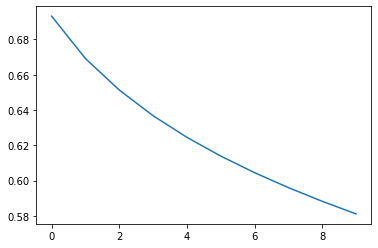

In [9]:
## the trend in the context of loss
plt.plot(costs)
plt.show()

## Credits

[Elvis](https://medium.com/dair-ai/implementing-a-logistic-regression-model-from-scratch-with-pytorch-24ea062cd856)